<a href="https://colab.research.google.com/github/mengwangk/dl-projects/blob/master/04_03_auto_ml_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Automated ML - Generate Data

In [ ]:
COLAB = True

DATASET_NAME = '4D.zip'

FEATURE_DATASET_PREFIX = 'feature_matrix_d2'

In [ ]:
if COLAB:
  !pip install -U featuretools
  # !sudo apt-get install git-lfs && git lfs install
  from google.colab import drive
  drive.mount('/content/gdrive')
  !rm -rf dl-projects
  !git clone https://github.com/mengwangk/dl-projects
  !cd dl-projects && ls

Requirement already up-to-date: featuretools in /usr/local/lib/python3.6/dist-packages (0.13.1)
Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Cloning into 'dl-projects'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (25/25), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 806 (delta 14), reused 0 (delta 0), pack-reused 781
Receiving objects: 100% (806/806), 68.19 MiB | 36.48 MiB/s, done.
Resolving deltas: 100% (462/462), done.
01_01_tensor.ipynb	       04_02_auto_ml_4.ipynb  d04_train_ml.ipynb
01_02_correlation.ipynb        04_02_auto_ml_5.ipynb  datasets
01_03_preprocessing.ipynb      04_03_auto_ml_1.ipynb  exp
01_04_numpy.ipynb	       04_10_basic_nn.ipynb   featurelib
01_05_parallelization.ipynb    04_11_cnn.ipynb	      LICENSE
01_06_pandas..ipynb	       04_12_rnn.ipynb	      lstm_s1.ipynb
01_07_python_0.ipynb	       04_13_embedding.ipynb  lstm_s2.ipynb


In [ ]:
if COLAB:
  !cp dl-projects/utils* .
  !cp dl-projects/preprocess* .

In [ ]:
%reload_ext autoreload
%autoreload 2

%matplotlib inline

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as ss
import math 
import matplotlib
import re

from scipy import stats
from collections import Counter
from pathlib import Path

plt.style.use('fivethirtyeight')

sns.set(style="ticks")

# Automated feature engineering
import featuretools as ft

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier

from IPython.display import display

from utils import *
from preprocess import *

# The Answer to the Ultimate Question of Life, the Universe, and Everything.
np.random.seed(42)

In [ ]:
%aimport

Modules to reload:
all-except-skipped

Modules to skip:



## Preparation

In [ ]:
if COLAB:
  DATASET_PATH = Path("dl-projects/datasets")
else:
  DATASET_PATH = Path("datasets")

DATASET = DATASET_PATH/DATASET_NAME

In [ ]:
data = format_tabular(DATASET)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106858 entries, 0 to 106857
Data columns (total 4 columns):
DrawNo       106858 non-null int64
DrawDate     106858 non-null datetime64[ns]
PrizeType    106858 non-null object
LuckyNo      106858 non-null int64
dtypes: datetime64[ns](1), int64(2), object(1)
memory usage: 3.3+ MB


In [ ]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo
106848,505320,2020-01-01,SpecialNo1,2404
106849,505320,2020-01-01,SpecialNo10,7382
106850,505320,2020-01-01,SpecialNo2,2220
106851,505320,2020-01-01,SpecialNo3,3573
106852,505320,2020-01-01,SpecialNo4,4524
106853,505320,2020-01-01,SpecialNo5,6856
106854,505320,2020-01-01,SpecialNo6,8107
106855,505320,2020-01-01,SpecialNo7,1026
106856,505320,2020-01-01,SpecialNo8,3960
106857,505320,2020-01-01,SpecialNo9,5472


In [ ]:
data['NumberId'] = data['LuckyNo']

In [ ]:
data.tail(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
106848,505320,2020-01-01,SpecialNo1,2404,2404
106849,505320,2020-01-01,SpecialNo10,7382,7382
106850,505320,2020-01-01,SpecialNo2,2220,2220
106851,505320,2020-01-01,SpecialNo3,3573,3573
106852,505320,2020-01-01,SpecialNo4,4524,4524
106853,505320,2020-01-01,SpecialNo5,6856,6856
106854,505320,2020-01-01,SpecialNo6,8107,8107
106855,505320,2020-01-01,SpecialNo7,1026,1026
106856,505320,2020-01-01,SpecialNo8,3960,3960
106857,505320,2020-01-01,SpecialNo9,5472,5472


## Data Cleansing

In [ ]:
def change_prize_type(x):
  if "Special" in x:
    return 'Special'
  elif "Consolation" in x:
    return 'Consolation'
  else:
    return x


data['PrizeType'] = data['PrizeType'].apply(change_prize_type)
# data['PrizeType'].isin(['SpecialNo1']).tail(23)

In [ ]:
data.tail(23)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId
106835,505320,2020-01-01,1stPrizeNo,875,875
106836,505320,2020-01-01,2ndPrizeNo,6307,6307
106837,505320,2020-01-01,3rdPrizeNo,8552,8552
106838,505320,2020-01-01,Consolation,2114,2114
106839,505320,2020-01-01,Consolation,4861,4861
106840,505320,2020-01-01,Consolation,508,508
106841,505320,2020-01-01,Consolation,2086,2086
106842,505320,2020-01-01,Consolation,3296,3296
106843,505320,2020-01-01,Consolation,413,413
106844,505320,2020-01-01,Consolation,4781,4781


In [ ]:
data.describe().round(2)

,DrawNo,LuckyNo,NumberId
count,106858.00,106858.00,106858.00
mean,273049.89,4973.57,4973.57
std,134131.48,2885.58,2885.58
min,40792.00,0.00,0.00
25%,156899.00,2462.00,2462.00
50%,273056.00,4951.00,4951.00
75%,389213.00,7463.00,7463.00
max,505320.00,9999.00,9999.00


       DrawNo   DrawDate    PrizeType  LuckyNo  NumberId
6007    66894 1994-01-05  Consolation     1760      1760
12089   93295 1995-09-10      Special     1760      1760
33221  185101 2001-06-09  Consolation     1760      1760
41325  220403 2003-08-10      Special     1760      1760
56402  286007 2007-06-24  Consolation     1760      1760
67267  333210 2010-04-10      Special     1760      1760
70041  345310 2010-12-19  Consolation     1760      1760
72759  357111 2011-08-21  Consolation     1760      1760
75155  367512 2012-03-20      Special     1760      1760
88140  424015 2015-05-17  Consolation     1760      1760
88193  424215 2015-05-23  Consolation     1760      1760
94840  453117 2017-01-04  Consolation     1760      1760


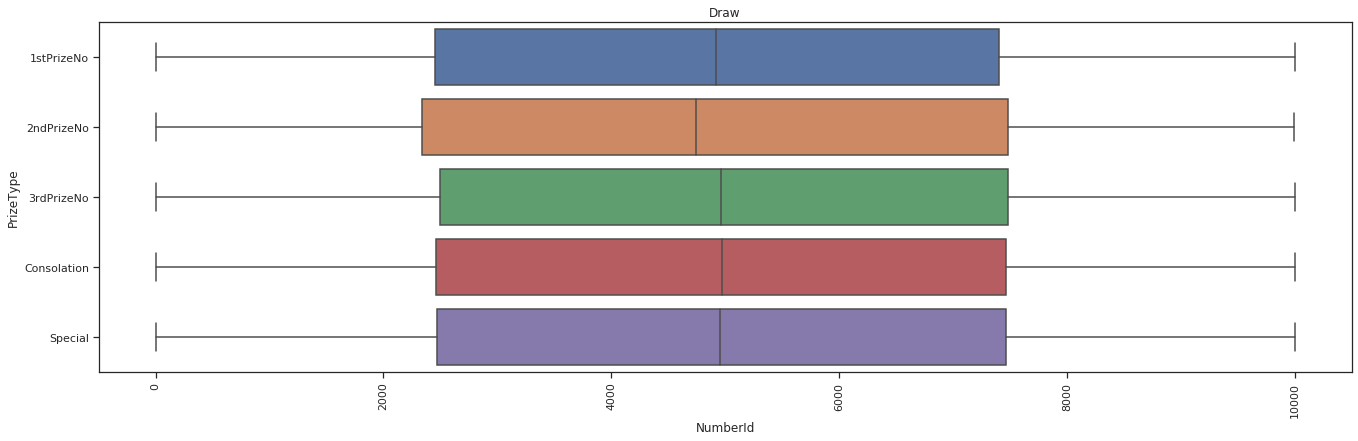

In [ ]:
plt.figure(figsize=(20,6))
sns.boxplot(x='NumberId', y='PrizeType',data=data)
plt.xticks(rotation=90)
plt.title('Draw')

print(data[data['NumberId']==1760])

## Exploration

In [ ]:
def ecdf(data):
    x = np.sort(data)
    y = np.arange(1, len(x) + 1) / len(x)
    return x, y

## Making Labels

In [ ]:
data['TotalStrike'] = 1
data.head(10)

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,40792,1992-05-06,1stPrizeNo,19,19,1
1,40792,1992-05-06,2ndPrizeNo,1124,1124,1
2,40792,1992-05-06,3rdPrizeNo,592,592,1
3,40792,1992-05-06,Consolation,5311,5311,1
4,40792,1992-05-06,Consolation,407,407,1
5,40792,1992-05-06,Consolation,1949,1949,1
6,40792,1992-05-06,Consolation,1606,1606,1
7,40792,1992-05-06,Consolation,3775,3775,1
8,40792,1992-05-06,Consolation,6226,6226,1
9,40792,1992-05-06,Consolation,1271,1271,1


In [ ]:
def make_cutoffs(start_date, end_date, threshold=0):
    # Find numbers exist before start date
    number_pool = data[data['DrawDate'] < start_date]['NumberId'].unique()
    tmp = pd.DataFrame({'NumberId': number_pool})
   
    # For numbers in the number pool, find their strike count between the start and end dates
    strike_counts = data[(data['NumberId'].isin(number_pool)) & 
        (data['DrawDate'] >= start_date) & 
        (data['DrawDate']< end_date)
    ].groupby('NumberId')['TotalStrike'].count().reset_index()
    
    number_of_draws = data[
                 (data['DrawDate'] >= start_date) & 
                 (data['DrawDate']< end_date)]['DrawDate'].nunique()
    # display(strike_counts)
    # print(number_of_draws)
    
    # Merge with all the number ids to record all customers who existed before start date
    strike_counts = strike_counts.merge(tmp, on='NumberId', how='right')
    
    # Set the total for any numbers who did not strike in the timeframe equal to 0
    strike_counts['TotalStrike'] = strike_counts['TotalStrike'].fillna(0)
    
    # Label is based on the threshold
    strike_counts['Label'] = (strike_counts['TotalStrike'] > threshold).astype(int)
        
    # The cutoff time is the start date
    strike_counts['cutoff_time'] = pd.to_datetime(start_date)
    strike_counts = strike_counts[['NumberId', 'cutoff_time', 'TotalStrike', 'Label']]
    
    #display(strike_counts[strike_counts['Label']==1].nunique())
    #display(strike_counts.sort_values(by='TotalStrike', ascending=False))
   
    return number_of_draws, strike_counts

In [ ]:
number_of_draws, may_2015 = make_cutoffs(pd.datetime(2015, 5, 1), pd.datetime(2015, 6, 1))
#display(len(may_2015))
#display(may_2015[may_2015['Label']==1].nunique())
may_2015[(may_2015['Label']==1) & (may_2015['TotalStrike']==2)].sort_values(by='TotalStrike', ascending=False).head()

,NumberId,cutoff_time,TotalStrike,Label
37,904,2015-05-01,2.0,1
66,1760,2015-05-01,2.0,1
114,3012,2015-05-01,2.0,1
333,9160,2015-05-01,2.0,1
340,9417,2015-05-01,2.0,1


In [ ]:
data[data['NumberId'].isin([904,1760])]

,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
6007,66894,1994-01-05,Consolation,1760,1760,1
12089,93295,1995-09-10,Special,1760,1760,1
12844,96595,1995-11-26,Consolation,904,904,1
27344,159599,1999-11-13,Special,904,904,1
30777,174500,2000-10-14,Consolation,904,904,1
33221,185101,2001-06-09,Consolation,1760,1760,1
41325,220403,2003-08-10,Special,1760,1760,1
44607,234704,2004-06-19,Consolation,904,904,1
50498,260305,2005-12-24,Special,904,904,1
52719,270006,2006-07-09,Consolation,904,904,1


Text(0.5, 1.0, 'Label Distribution for May')

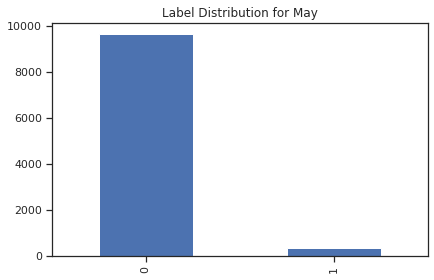

In [ ]:
may_2015['Label'].value_counts().plot.bar()
plt.title('Label Distribution for May')

In [ ]:
CUT_OFF_YEAR=pd.datetime(2014, 1, 1)

In [ ]:
## Loop through each month starting from CUT_OFF_YEAR

from dateutil.relativedelta import relativedelta

# print(data['DrawDate'].max())
max_year_month = data['DrawDate'].max() - relativedelta(months=1) + relativedelta(day=31)
print(f"Max month year: {max_year_month}")

start_year_month = CUT_OFF_YEAR

months_data = []
total_draws = 0
while start_year_month < max_year_month:
    start_date = start_year_month 
    end_date = start_date + relativedelta(months=1)
    start_year_month = start_year_month + relativedelta(months=1)
    #print(f"Labels from {start_date} to {end_date}")
    draw_count, month_data = make_cutoffs(start_date, end_date)
    total_draws = total_draws + draw_count
    months_data.append(month_data)

print(f"Total draws: {total_draws}")
print(f"Total draws: {data[(data['DrawDate'] >= CUT_OFF_YEAR) & (data['DrawDate'] <= max_year_month)]['DrawDate'].nunique()}")
print(f"Total months:{len(months_data)}")
print(f"Total records count: {sum([len(l) for l in months_data])}")
print([len(l) for l in months_data])

Max month year: 2019-12-31 00:00:00
Total draws: 1060
Total draws: 1060
Total months:72
Total records count: 719972
[9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9998, 9999, 9999, 9999, 9999, 9999, 9999, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000, 10000]


In [ ]:
labels = pd.concat(months_data)
labels.to_csv(DATASET_PATH/'labels.csv')
labels.describe()

,NumberId,TotalStrike,Label
count,719972.000000,719972.000000,719972.000000
mean,4999.417276,0.033860,0.033283
std,2886.751039,0.184057,0.179375
min,0.000000,0.000000,0.000000
25%,2499.000000,0.000000,0.000000
50%,4999.000000,0.000000,0.000000
75%,7499.000000,0.000000,0.000000
max,9999.000000,3.000000,1.000000


In [ ]:
# plot_labels = labels.copy()
# plot_labels['month'] = plot_labels['cutoff_time'].dt.month

# plt.figure(figsize = (12, 6))
# sns.boxplot(x = 'month', y = 'TotalStrike', 
#             data = plot_labels[(plot_labels['TotalStrike'] > 0)]);
# plt.title('Distribution by Month');

In [ ]:
labels[(labels['NumberId'] == 9016)  & (labels['Label'] > 0)]

,NumberId,cutoff_time,TotalStrike,Label
307,9016,2014-10-01,1.0,1
305,9016,2016-05-01,1.0,1


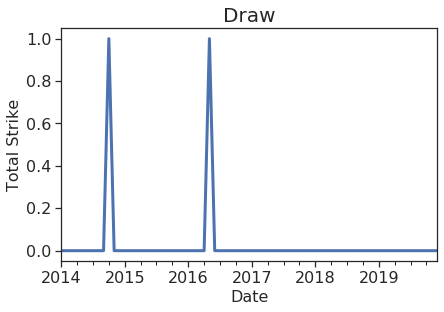

In [ ]:
labels.loc[labels['NumberId'] == 9016].set_index('cutoff_time')['TotalStrike'].plot(figsize = (6, 4), linewidth = 3)
plt.xlabel('Date', size = 16); 
plt.ylabel('Total Strike', size = 16); 
plt.title('Draw', size = 20);
plt.xticks(size = 16); plt.yticks(size = 16);

In [ ]:
labels.tail(10)

,NumberId,cutoff_time,TotalStrike,Label
9990,4949,2019-12-01,0.0,0
9991,3479,2019-12-01,0.0,0
9992,6512,2019-12-01,0.0,0
9993,4996,2019-12-01,0.0,0
9994,3852,2019-12-01,0.0,0
9995,7940,2019-12-01,0.0,0
9996,5407,2019-12-01,0.0,0
9997,7709,2019-12-01,0.0,0
9998,9659,2019-12-01,0.0,0
9999,5488,2019-12-01,0.0,0


## Automated Feature Engineering

In [ ]:
es = ft.EntitySet(id="Lotto Results")

# Add the entire data table as an entity
es.entity_from_dataframe("Results",
                         dataframe=data,
                         index="results_index",
                         time_index = 'DrawDate')

es['Results']

2020-01-04 00:25:17,819 featuretools.entityset - WARNING    index results_index not found in dataframe, creating new integer column


Entity: Results
  Variables:
    results_index (dtype: index)
    DrawNo (dtype: numeric)
    DrawDate (dtype: datetime_time_index)
    PrizeType (dtype: categorical)
    LuckyNo (dtype: numeric)
    NumberId (dtype: numeric)
    TotalStrike (dtype: numeric)
  Shape:
    (Rows: 106858, Columns: 7)

In [ ]:
es.normalize_entity(new_entity_id="Numbers",
                    base_entity_id="Results",
                    index="NumberId",
                    )

Entityset: Lotto Results
  Entities:
    Results [Rows: 106858, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [ ]:
es

Entityset: Lotto Results
  Entities:
    Results [Rows: 106858, Columns: 7]
    Numbers [Rows: 10000, Columns: 2]
  Relationships:
    Results.NumberId -> Numbers.NumberId

In [ ]:
es['Numbers'].df.head(24)

,NumberId,first_Results_time
19,19,1992-05-06
1124,1124,1992-05-06
592,592,1992-05-06
5311,5311,1992-05-06
407,407,1992-05-06
1949,1949,1992-05-06
1606,1606,1992-05-06
3775,3775,1992-05-06
6226,6226,1992-05-06
1271,1271,1992-05-06


In [ ]:
es['Results'].df.head(24)

,results_index,DrawNo,DrawDate,PrizeType,LuckyNo,NumberId,TotalStrike
0,0,40792,1992-05-06,1stPrizeNo,19,19,1
1,1,40792,1992-05-06,2ndPrizeNo,1124,1124,1
2,2,40792,1992-05-06,3rdPrizeNo,592,592,1
3,3,40792,1992-05-06,Consolation,5311,5311,1
4,4,40792,1992-05-06,Consolation,407,407,1
5,5,40792,1992-05-06,Consolation,1949,1949,1
6,6,40792,1992-05-06,Consolation,1606,1606,1
7,7,40792,1992-05-06,Consolation,3775,3775,1
8,8,40792,1992-05-06,Consolation,6226,6226,1
9,9,40792,1992-05-06,Consolation,1271,1271,1


In [ ]:
len(es['Results'].df)

106858

## Deep Feature Synthesis

In [ ]:
# feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
#                                        cutoff_time = labels, verbose = 2,
#                                        cutoff_time_in_index = True,
#                                        chunk_size = len(labels), n_jobs = 1,
#                                        max_depth = 1)

In [ ]:
default_agg_primitives =  ['std', 'max', 'min', 'mode', 'mean', 'skew', 'last', 'avg_time_between', 
                            'count', 'sum', 'trend', 'percent_true', 'num_unique']
default_trans_primitives =  ['cum_sum', 'cum_mean', 'day', 'month', 'hour', 'percentile', 'and', 'time_since']

feature_matrix, feature_names = ft.dfs(entityset=es, target_entity='Numbers',
                                       agg_primitives = default_agg_primitives ,
                                       trans_primitives = default_trans_primitives,
                                       cutoff_time = labels, verbose = 1,
                                       cutoff_time_in_index = True,
                                       chunk_size = len(labels), n_jobs = 1,
                                       max_depth = 2)

Built 207 features
Elapsed: 6:53:45 | Progress: 100%|██████████


In [ ]:
len(feature_matrix.columns), feature_matrix.columns

(209, Index(['STD(Results.DrawNo)', 'STD(Results.LuckyNo)',
        'STD(Results.TotalStrike)', 'MAX(Results.DrawNo)',
        'MAX(Results.LuckyNo)', 'MAX(Results.TotalStrike)',
        'MIN(Results.DrawNo)', 'MIN(Results.LuckyNo)',
        'MIN(Results.TotalStrike)', 'MODE(Results.PrizeType)',
        ...
        'PERCENTILE(LAST(Results.LuckyNo))',
        'PERCENTILE(SKEW(Results.TotalStrike))',
        'PERCENTILE(MIN(Results.LuckyNo))', 'PERCENTILE(STD(Results.DrawNo))',
        'PERCENTILE(MEAN(Results.TotalStrike))',
        'PERCENTILE(STD(Results.LuckyNo))',
        'PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate))',
        'PERCENTILE(STD(Results.TotalStrike))', 'TotalStrike', 'Label'],
       dtype='object', length=209))

In [ ]:
len(feature_matrix)

719972

719972

In [ ]:
feature_matrix.head().T

NumberId,45,64,81,93,140
time,2014-01-01,2014-01-01,2014-01-01,2014-01-01,2014-01-01
STD(Results.DrawNo),112624,120519,113968,127901,122955
STD(Results.LuckyNo),0,0,0,0,0
STD(Results.TotalStrike),0,0,0,0,0
MAX(Results.DrawNo),380012,375112,358811,363111,363311
MAX(Results.LuckyNo),45,64,81,93,140
...,...,...,...,...,...
PERCENTILE(STD(Results.LuckyNo)),0.50005,0.50005,0.50005,0.50005,0.50005
PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),0.170524,0.88408,0.67869,0.952309,0.685502
PERCENTILE(STD(Results.TotalStrike)),0.50005,0.50005,0.50005,0.50005,0.50005


NumberId,45,64,81,93,140
time,2014-01-01,2014-01-01,2014-01-01,2014-01-01,2014-01-01
STD(Results.DrawNo),112624,120519,113968,127901,122955
STD(Results.LuckyNo),0,0,0,0,0
STD(Results.TotalStrike),0,0,0,0,0
MAX(Results.DrawNo),380012,375112,358811,363111,363311
MAX(Results.LuckyNo),45,64,81,93,140
...,...,...,...,...,...
PERCENTILE(STD(Results.LuckyNo)),0.50005,0.50005,0.50005,0.50005,0.50005
PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),0.170524,0.88408,0.67869,0.952309,0.685502
PERCENTILE(STD(Results.TotalStrike)),0.50005,0.50005,0.50005,0.50005,0.50005


In [ ]:
feature_matrix.shape

(719972, 209)

In [ ]:
feature_matrix.head(2)

,,STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MODE(Results.PrizeType),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),LAST(Results.PrizeType),LAST(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),"TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.TotalStrike, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),...,CUM_MEAN(LAST(Results.LuckyNo)),CUM_MEAN(SKEW(Results.TotalStrike)),CUM_MEAN(MIN(Results.LuckyNo)),CUM_MEAN(STD(Results.DrawNo)),CUM_MEAN(MEAN(Results.TotalStrike)),CUM_MEAN(STD(Results.LuckyNo)),CUM_MEAN(AVG_TIME_BETWEEN(Results.DrawDate)),CUM_MEAN(STD(Results.TotalStrike)),DAY(LAST(Results.DrawDate)),MONTH(LAST(Results.DrawDate)),HOUR(LAST(Results.DrawDate)),PERCENTILE(SKEW(Results.LuckyNo)),PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(COUNT(Results)),PERCENTILE(LAST(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(STD(Results.TotalStrike)),TotalStrike,Label
NumberId,time,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
45,2014-01-01,112624.014707,0.0,0.0,380012,45,1,97695,45,1,Consolation,279760.909091,45,1,-0.930399,0.0,0.0,1stPrizeNo,380012,45,1,78016,53472960.0,11,3077370,495,11,45.560053,0.0,0.0,3,23,12,0,568857600.0,0.0,5.101631,25901.838735,6.189125e+09,1.288990e+08,0.314047,...,4997.114933,0.0,4997.114933,107243.033829,1.0,0.0,8.364835e+07,0.0,2,12,0,0.500051,0.954191,0.088030,0.641928,0.826365,0.50005,0.500051,0.004601,0.580366,0.641928,0.751189,0.939988,0.732947,0.004601,0.008102,0.826365,0.50005,0.500051,0.50005,0.004601,0.500051,0.004601,0.701934,0.50005,0.50005,0.170524,0.50005,1.0,1
64,2014-01-01,120519.321745,0.0,0.0,375112,64,1,61593,64,1,Special,230353.500000,64,1,-0.167286,0.0,0.0,Consolation,375112,64,1,76900,119802240.0,6,1382121,384,6,45.316013,0.0,0.0,3,2,9,0,641606400.0,0.0,8.481822,27713.008869,6.313569e+09,1.379830e+08,0.336035,...,5000.955181,0.0,5000.955181,110985.126539,1.0,0.0,8.415706e+07,0.0,26,8,0,0.500051,0.285457,0.389659,0.572615,0.226895,0.50005,0.500051,0.006501,0.580366,0.572615,0.567641,0.609822,0.378876,0.006501,0.006501,0.226895,0.50005,0.500051,0.50005,0.006501,0.500051,0.006501,0.826070,0.50005,0.50005,0.884080,0.50005,1.0,1


In [ ]:
#feature_matrix[(feature_matrix['NumberId']==0) & (feature_matrix['Label']==1)].head(10)

## Correlations

In [ ]:
# Save the original feature matrix
origin_feature_matrix = feature_matrix

feature_matrix = pd.get_dummies(feature_matrix).reset_index()
feature_matrix.shape

(719972, 219)

In [ ]:
feature_matrix.head(10)

,NumberId,time,STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),LAST(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),"TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.TotalStrike, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),...,PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(COUNT(Results)),PERCENTILE(LAST(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(STD(Results.TotalStrike)),TotalStrike,Label,MODE(Results.PrizeType)_1stPrizeNo,MODE(Results.PrizeType)_2ndPrizeNo,MODE(Results.PrizeType)_3rdPrizeNo,MODE(Results.PrizeType)_Consolation,MODE(Results.PrizeType)_Special,LAST(Results.PrizeType)_1stPrizeNo,LAST(Results.PrizeType)_2ndPrizeNo,LAST(Results.PrizeType)_3rdPrizeNo,LAST(Results.PrizeType)_Consolation,LAST(Results.PrizeType)_Special,month,year
0,45,2014-01-01,112624.014707,0.0,0.0,380012,45,1,97695,45,1,279760.909091,45,1,-0.930399,0.0,0.0,380012,45,1,78016,5.347296e+07,11,3077370,495,11,45.560053,0.0,0.0,3,23,12,0,568857600.0,0.0,5.101631,25901.838735,6.189125e+09,1.288990e+08,0.314047,...,0.954191,0.088030,0.641928,0.826365,0.50005,0.500051,0.004601,0.580366,0.641928,0.751189,0.939988,0.732947,0.004601,0.008102,0.826365,0.50005,0.500051,0.50005,0.004601,0.500051,0.004601,0.701934,0.50005,0.50005,0.170524,0.50005,1.0,1,0,0,0,1,0,1,0,0,0,0,1,2014
1,64,2014-01-01,120519.321745,0.0,0.0,375112,64,1,61593,64,1,230353.500000,64,1,-0.167286,0.0,0.0,375112,64,1,76900,1.198022e+08,6,1382121,384,6,45.316013,0.0,0.0,3,2,9,0,641606400.0,0.0,8.481822,27713.008869,6.313569e+09,1.379830e+08,0.336035,...,0.285457,0.389659,0.572615,0.226895,0.50005,0.500051,0.006501,0.580366,0.572615,0.567641,0.609822,0.378876,0.006501,0.006501,0.226895,0.50005,0.500051,0.50005,0.006501,0.500051,0.006501,0.826070,0.50005,0.50005,0.884080,0.50005,1.0,1,0,0,0,0,1,0,0,0,1,0,1,2014
2,81,2014-01-01,113967.559506,0.0,0.0,358811,81,1,41792,81,1,211827.500000,81,1,-0.543717,0.0,0.0,358811,81,1,73156,8.715291e+07,8,1694620,648,8,44.679995,0.0,0.0,2,28,5,0,681523200.0,0.0,31.435416,26209.269549,5.083894e+09,1.304944e+08,0.317785,...,0.458742,0.198017,0.397880,0.490798,0.50005,0.500051,0.008202,0.192488,0.397880,0.129313,0.415433,0.023955,0.008202,0.010202,0.490798,0.50005,0.500051,0.50005,0.008202,0.500051,0.008202,0.726280,0.50005,0.50005,0.678690,0.50005,1.0,1,0,0,0,1,0,0,0,0,0,1,1,2014
3,93,2014-01-01,127901.309529,0.0,0.0,363111,93,1,41892,93,1,181780.400000,93,1,0.469604,0.0,0.0,363111,93,1,74151,1.543536e+08,5,908902,4

In [ ]:
corrs = feature_matrix.corr().sort_values('TotalStrike')
corrs['TotalStrike'].head()

LAST(Results.DAY(DrawDate))          -0.011889
DAY(LAST(Results.DrawDate))          -0.011889
MIN(Results.TIME_SINCE(DrawDate))    -0.005543
LAST(Results.TIME_SINCE(DrawDate))   -0.005543
MEAN(Results.TIME_SINCE(DrawDate))   -0.005068
Name: TotalStrike, dtype: float64

In [ ]:
corrs['TotalStrike'].dropna().tail(60)

COUNT(Results)                                      0.001909
SUM(Results.TotalStrike)                            0.001909
SUM(Results.CUM_MEAN(TotalStrike))                  0.001909
SUM(Results.PERCENTILE(TotalStrike))                0.001909
CUM_SUM(MIN(Results.DrawNo))                        0.001933
MIN(Results.PERCENTILE(DrawNo))                     0.001937
PERCENTILE(COUNT(Results))                          0.001968
PERCENTILE(SUM(Results.TotalStrike))                0.001968
PERCENTILE(STD(Results.LuckyNo))                    0.002024
PERCENTILE(STD(Results.TotalStrike))                0.002024
STD(Results.CUM_SUM(DrawNo))                        0.002390
STD(Results.PERCENTILE(DrawNo))                     0.002420
PERCENTILE(STD(Results.DrawNo))                     0.002459
PERCENTILE(TREND(Results.TotalStrike, DrawDate))    0.002542
PERCENTILE(SKEW(Results.TotalStrike))               0.002542
PERCENTILE(TREND(Results.LuckyNo, DrawDate))        0.002542
PERCENTILE(SKEW(Results.

In [ ]:
# g = sns.FacetGrid(feature_matrix[(feature_matrix['SUM(Results.DrawNo)'] > 0)],
#                   hue = 'Label', size = 4, aspect = 3)
# g.map(sns.kdeplot, 'SUM(Results.DrawNo)')
# g.add_legend();
# plt.title('Distribution of Results Total by Label');

In [ ]:
feature_matrix['month'] = feature_matrix['time'].dt.month
feature_matrix['year'] = feature_matrix['time'].dt.year

In [ ]:
feature_matrix.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 719972 entries, 0 to 719971
Columns: 221 entries, NumberId to year
dtypes: datetime64[ns](1), float64(146), int64(64), uint8(10)
memory usage: 1.1 GB


In [ ]:
feature_matrix.head()

,NumberId,time,STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),LAST(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),"TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.TotalStrike, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),...,PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(COUNT(Results)),PERCENTILE(LAST(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(STD(Results.TotalStrike)),TotalStrike,Label,MODE(Results.PrizeType)_1stPrizeNo,MODE(Results.PrizeType)_2ndPrizeNo,MODE(Results.PrizeType)_3rdPrizeNo,MODE(Results.PrizeType)_Consolation,MODE(Results.PrizeType)_Special,LAST(Results.PrizeType)_1stPrizeNo,LAST(Results.PrizeType)_2ndPrizeNo,LAST(Results.PrizeType)_3rdPrizeNo,LAST(Results.PrizeType)_Consolation,LAST(Results.PrizeType)_Special,month,year
0,45,2014-01-01,112624.014707,0.0,0.0,380012,45,1,97695,45,1,279760.909091,45,1,-0.930399,0.0,0.0,380012,45,1,78016,5.347296e+07,11,3077370,495,11,45.560053,0.0,0.0,3,23,12,0,568857600.0,0.0,5.101631,25901.838735,6.189125e+09,1.288990e+08,0.314047,...,0.954191,0.088030,0.641928,0.826365,0.50005,0.500051,0.004601,0.580366,0.641928,0.751189,0.939988,0.732947,0.004601,0.008102,0.826365,0.50005,0.500051,0.50005,0.004601,0.500051,0.004601,0.701934,0.50005,0.50005,0.170524,0.50005,1.0,1,0,0,0,1,0,1,0,0,0,0,1,2014
1,64,2014-01-01,120519.321745,0.0,0.0,375112,64,1,61593,64,1,230353.500000,64,1,-0.167286,0.0,0.0,375112,64,1,76900,1.198022e+08,6,1382121,384,6,45.316013,0.0,0.0,3,2,9,0,641606400.0,0.0,8.481822,27713.008869,6.313569e+09,1.379830e+08,0.336035,...,0.285457,0.389659,0.572615,0.226895,0.50005,0.500051,0.006501,0.580366,0.572615,0.567641,0.609822,0.378876,0.006501,0.006501,0.226895,0.50005,0.500051,0.50005,0.006501,0.500051,0.006501,0.826070,0.50005,0.50005,0.884080,0.50005,1.0,1,0,0,0,0,1,0,0,0,1,0,1,2014
2,81,2014-01-01,113967.559506,0.0,0.0,358811,81,1,41792,81,1,211827.500000,81,1,-0.543717,0.0,0.0,358811,81,1,73156,8.715291e+07,8,1694620,648,8,44.679995,0.0,0.0,2,28,5,0,681523200.0,0.0,31.435416,26209.269549,5.083894e+09,1.304944e+08,0.317785,...,0.458742,0.198017,0.397880,0.490798,0.50005,0.500051,0.008202,0.192488,0.397880,0.129313,0.415433,0.023955,0.008202,0.010202,0.490798,0.50005,0.500051,0.50005,0.008202,0.500051,0.008202,0.726280,0.50005,0.50005,0.678690,0.50005,1.0,1,0,0,0,1,0,0,0,0,0,1,1,2014
3,93,2014-01-01,127901.309529,0.0,0.0,363111,93,1,41892,93,1,181780.400000,93,1,0.469604,0.0,0.0,363111,93,1,74151,1.543536e+08,5,908902,4

In [ ]:
feature_matrix.tail()

,NumberId,time,STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),LAST(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),"TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.TotalStrike, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),...,PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(COUNT(Results)),PERCENTILE(LAST(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(STD(Results.TotalStrike)),TotalStrike,Label,MODE(Results.PrizeType)_1stPrizeNo,MODE(Results.PrizeType)_2ndPrizeNo,MODE(Results.PrizeType)_3rdPrizeNo,MODE(Results.PrizeType)_Consolation,MODE(Results.PrizeType)_Special,LAST(Results.PrizeType)_1stPrizeNo,LAST(Results.PrizeType)_2ndPrizeNo,LAST(Results.PrizeType)_3rdPrizeNo,LAST(Results.PrizeType)_Consolation,LAST(Results.PrizeType)_Special,month,year
719967,7940,2019-12-01,43816.929073,0.0,0.0,473918,7940,1,358611,7940,1,399980.166667,7940,1,1.185862,0.0,0.0,473918,7940,1,99633,4.064256e+07,6,2399881,47640,6,48.968637,0.0,0.0,2,24,9,0,258336000.0,0.0,1.183311,10079.462261,4.208884e+09,5.009341e+07,0.094591,...,0.3249,0.974877,0.49830,0.0700,0.50005,0.50005,0.7941,0.13345,0.49830,1.000000,0.9973,0.9995,0.7941,0.49695,0.0700,0.50005,0.50005,0.50005,0.7941,0.50005,0.7941,0.0015,0.50005,0.50005,0.0140,0.50005,0.0,0,0,0,0,0,1,0,0,0,0,1,12,2019
719968,5407,2019-12-01,33816.271769,0.0,0.0,426715,5407,1,366112,5407,1,405080.666667,5407,1,-1.700598,0.0,0.0,426715,5407,1,88778,5.365440e+07,3,1215242,16221,3,48.846408,0.0,0.0,2,19,2,0,245548800.0,0.0,1.968982,7771.970235,3.074048e+09,3.854211e+07,0.073002,...,0.0301,0.006206,0.16490,0.0040,0.50005,0.50005,0.5408,0.13345,0.16490,0.999700,0.9981,0.9996,0.5408,0.16640,0.0040,0.50005,0.50005,0.50005,0.5408,0.50005,0.5408,0.0007,0.50005,0.50005,0.1281,0.50005,0.0,0,0,0,0,0,1,0,0,0,0,1,12,2019
719969,7709,2019-12-01,39368.855047,0.0,0.0,501619,7709,1,373212,7709,1,438690.500000,7709,1,0.112795,0.0,0.0,501619,7709,1,105992,3.264686e+07,8,3509524,61672,8,48.614893,0.0,0.0,3,15,7,0,232848000.0,0.0,1.602046,9055.400179,3.992931e+09,4.493147e+07,0.084988,...,0.7427,0.585427,0.94815,0.2153,0.50005,0.50005,0.7710,0.47805,0.94815,0.997798,0.9998,0.9997,0.7710,0.62900,0.2153,0.50005,0.50005,0.50005,0.7710,0.50005,0.7710,0.0011,0.50005,0.50005,0.0013,0.50005,0.0,0,0,0,0,1,0,0,0,0,1,0,12,2019
719970,9659,2019-12-01,30474.905355,0.0,0.0,488518,9659,1,414714,9659,1,460600.000000,9659,1,-0.788556,0.0,0.0,488518,9659,1,102978,2.607552e+07,6,2763600,57954,6,48.862577,0.0,

In [ ]:
display(feature_matrix.describe())

,NumberId,STD(Results.DrawNo),STD(Results.LuckyNo),STD(Results.TotalStrike),MAX(Results.DrawNo),MAX(Results.LuckyNo),MAX(Results.TotalStrike),MIN(Results.DrawNo),MIN(Results.LuckyNo),MIN(Results.TotalStrike),MEAN(Results.DrawNo),MEAN(Results.LuckyNo),MEAN(Results.TotalStrike),SKEW(Results.DrawNo),SKEW(Results.LuckyNo),SKEW(Results.TotalStrike),LAST(Results.DrawNo),LAST(Results.LuckyNo),LAST(Results.TotalStrike),LAST(Results.results_index),AVG_TIME_BETWEEN(Results.DrawDate),COUNT(Results),SUM(Results.DrawNo),SUM(Results.LuckyNo),SUM(Results.TotalStrike),"TREND(Results.DrawNo, DrawDate)","TREND(Results.LuckyNo, DrawDate)","TREND(Results.TotalStrike, DrawDate)",NUM_UNIQUE(Results.PrizeType),DAY(first_Results_time),MONTH(first_Results_time),HOUR(first_Results_time),TIME_SINCE(first_Results_time),STD(Results.PERCENTILE(TotalStrike)),STD(Results.CUM_MEAN(LuckyNo)),STD(Results.CUM_SUM(TotalStrike)),STD(Results.CUM_SUM(DrawNo)),STD(Results.CUM_SUM(LuckyNo)),STD(Results.PERCENTILE(DrawNo)),STD(Results.CUM_MEAN(TotalStrike)),...,PERCENTILE(SUM(Results.DrawNo)),PERCENTILE(SKEW(Results.DrawNo)),PERCENTILE(MAX(Results.DrawNo)),PERCENTILE(SUM(Results.TotalStrike)),PERCENTILE(MAX(Results.TotalStrike)),"PERCENTILE(TREND(Results.LuckyNo, DrawDate))",PERCENTILE(MAX(Results.LuckyNo)),PERCENTILE(NUM_UNIQUE(Results.PrizeType)),PERCENTILE(LAST(Results.DrawNo)),"PERCENTILE(TREND(Results.DrawNo, DrawDate))",PERCENTILE(MEAN(Results.DrawNo)),PERCENTILE(MIN(Results.DrawNo)),PERCENTILE(MEAN(Results.LuckyNo)),PERCENTILE(SUM(Results.LuckyNo)),PERCENTILE(COUNT(Results)),PERCENTILE(LAST(Results.TotalStrike)),"PERCENTILE(TREND(Results.TotalStrike, DrawDate))",PERCENTILE(MIN(Results.TotalStrike)),PERCENTILE(LAST(Results.LuckyNo)),PERCENTILE(SKEW(Results.TotalStrike)),PERCENTILE(MIN(Results.LuckyNo)),PERCENTILE(STD(Results.DrawNo)),PERCENTILE(MEAN(Results.TotalStrike)),PERCENTILE(STD(Results.LuckyNo)),PERCENTILE(AVG_TIME_BETWEEN(Results.DrawDate)),PERCENTILE(STD(Results.TotalStrike)),TotalStrike,Label,MODE(Results.PrizeType)_1stPrizeNo,MODE(Results.PrizeType)_2ndPrizeNo,MODE(Results.PrizeType)_3rdPrizeNo,MODE(Results.PrizeType)_Consolation,MODE(Results.PrizeType)_Special,LAST(Results.PrizeType)_1stPrizeNo,LAST(Results.PrizeType)_2ndPrizeNo,LAST(Results.PrizeType)_3rdPrizeNo,LAST(Results.PrizeType)_Consolation,LAST(Results.PrizeType)_Special,month,year
count,719972.000000,719575.000000,719575.0,719575.0,719972.000000,719972.000000,719972.0,719972.000000,719972.000000,719972.0,719972.000000,719972.000000,719972.0,716346.000000,716346.0,716346.0,719972.000000,719972.000000,719972.0,719972.000000,7.195750e+05,719972.000000,7.199720e+05,719972.000000,719972.000000,716346.000000,716346.0,716346.0,719972.000000,719972.000000,719972.000000,719972.0,7.199720e+05,719575.0,719575.000000,719575.000000,7.195750e+05,7.195750e+05,719575.000000,719575.0,...,719972.000000,716346.000000,719972.000000,719972.000000,7.199720e+05,7.163460e+05,719972.000000,719972.000000,719972.000000,716346.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,7.199720e+05,7.163460e+05,7.199720e+05,719972.000000,7.163460e+05,719972.000000,719575.000000,7.199720e+05,7.195750e+05,719575.000000,7.195750e+05,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000,719972.000000
mean,4999.417276,116567.051627,0.0,0.0,408749.774787,4999.417276,1.0,83975.582538,4999.417276,1.0,246339.718037,4999.417276,1.0,-0.001134,0.0,0.0,408749.774787,4999.417276,1.0,84636.291517,8.217225e+07,9.460332,2.341902e+06,47081.535204,9.460332,45.744578,0.0,0.0,2.976210,15.660688,6.671373,0.0,6.901673e+08,0.0,11.446285,26807.831403,6.750712e+09,1.334280e+08,0.283322,0.0,...,0.500050,0.500050,0.500050,0.500050,5.000500e-01,5.000503e-01,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,0.500050,5.000500e-01,5.000503e-01,5.000500e-01,0.500050,5.000503e-01,0.50005

## Save feature matrix

In [ ]:
#if COLAB:
#  feature_matrix.to_csv(DATASET_PATH/'feature_matrix.csv', index=False)
#  feature_matrix.to_pickle(DATASET_PATH/'feature_matrix.pkl')

### Save the data

https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

In [ ]:
if COLAB:
  #!cd dl-projects && git config --global user.email 'mengwangk@gmail.com' 
  #!cd dl-projects && git config --global user.name 'mengwangk'
  #!cd dl-projects && git add -A && git commit -m 'Updated from colab' 
  # from google.colab import drive
  # drive.mount('/content/gdrive')
  GDRIVE_DATASET_FOLDER = Path('gdrive/My Drive/datasets/')
  #!ls /content/gdrive/My\ Drive/
  
  feature_matrix.to_csv(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}.csv", index=False)
  feature_matrix.to_pickle(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}.pkl")
  origin_feature_matrix.to_pickle(GDRIVE_DATASET_FOLDER/f"{FEATURE_DATASET_PREFIX}_origin.pkl")

In [ ]:
#if COLAB:
#  !cd dl-projects && git remote rm origin && git remote add origin https://mengwangk:XX@github.com/mengwangk/dl-projects.git && git push -u origin master

In [ ]:
# from google.colab import files
# files.download(DATASET_PATH/'feature_matrix.csv') 

In [ ]:
if COLAB:
  !cd gdrive/"My Drive"/datasets/ && ls -l --block-size=M

total 3954M
-rw------- 1 root root  407M Dec 30 05:00 feature_matrix_2.csv
-rw------- 1 root root  428M Dec 30 05:01 feature_matrix_2.pkl
-rw------- 1 root root  141M Dec 27 08:27 feature_matrix.csv
-rw------- 1 root root 1637M Jan  4 07:34 feature_matrix_d2.csv
-rw------- 1 root root 1166M Jan  4 07:35 feature_matrix_d2.pkl
-rw------- 1 root root  176M Dec 27 08:28 feature_matrix.pkl
